In [22]:
!mkdir results
!ls
!ls results

mkdir: `results' 디렉토리를 만들 수 없습니다: 파일이 있습니다
 Lab6_result_report.ipynb  'Practice Json.ipynb'   data   results   test.json


In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

## Data preparation

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [25]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validation, Test and Experiment

In [26]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [27]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [32]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [33]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

## Manage Experiment Results

In [40]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size'] ## epoch, batch_size는 실험에 영향을 미치지 않는 변수이기 때문에 삭제

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) ## result라는 dic에 setting도 합치기 위함
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [35]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) ## args.name_var1 = var1 과 같은 말
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 37.93/40.11, Loss(train/val) 2.39/1.76. Took 3.32 sec
Epoch 1, Acc(train/val): 46.06/40.14, Loss(train/val) 1.56/1.88. Took 3.38 sec
Epoch 2, Acc(train/val): 48.86/38.09, Loss(train/val) 1.49/1.95. Took 3.31 sec
Epoch 3, Acc(train/val): 51.05/41.65, Loss(train/val) 1.44/1.91. Took 3.29 sec
Epoch 4, Acc(train/val): 53.55/41.94, Loss(train/val) 1.37/1.92. Took 3.34 sec
Epoch 5, Acc(train/val): 54.81/40.10, Loss(train/val) 1.32/2.17. Took 3.34 sec
Epoch 6, Acc(train/val): 56.70/48.40, Loss(train/val) 1.29/1.51. Took 3.32 sec
Epoch 7, Acc(train/val): 58.38/45.90, Loss(train/val) 1.23/1.68. Took 3.36 sec
Epoch 8, Acc(train/val): 59.91/36.88, Loss(train/val) 1.20/2.59. Took 3.38 sec
Epoch 9, Acc(train/val): 61.64/48.18, Loss(train/v

In [36]:
!ls results

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json


In [37]:
!cat results/exp1_n_layer_hid_dim-41b634.json

{"train_losses": [1.771469005353891, 1.511117148551212, 1.3933063912543522, 1.3230268484467913, 1.2527304341079324, 1.1940960436110284, 1.1340343071396943, 1.082287361287767, 1.0271685385400322, 0.98241188609676], "val_losses": [1.7214785099029541, 1.4902804374694825, 1.7634827256202699, 1.6370152831077576, 1.3871952652931214, 1.5624906778335572, 1.614415740966797, 1.4591437935829163, 1.5096706032752991, 1.5497953176498414], "train_accs": [36.3375, 45.9, 50.0525, 52.72, 55.1975, 57.6275, 59.6, 61.3275, 63.135, 65.0575], "val_accs": [38.81, 45.97, 40.39, 44.18, 50.55, 47.27, 45.69, 49.94, 50.12, 49.66], "train_acc": 65.0575, "val_acc": 49.66, "test_acc": 49.89, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}

In [44]:
print(type(load_exp_result('exp1')))

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

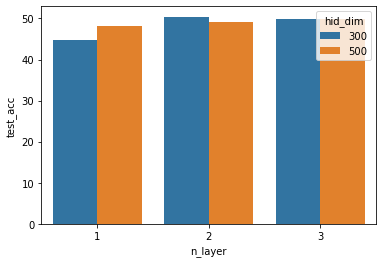

In [63]:
result=load_exp_result('exp1')

import seaborn as sns


sns.barplot(x='n_layer',y='test_acc',hue='hid_dim',data=result) ## hue는 계열 또는 범례를 뜻한다.

<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

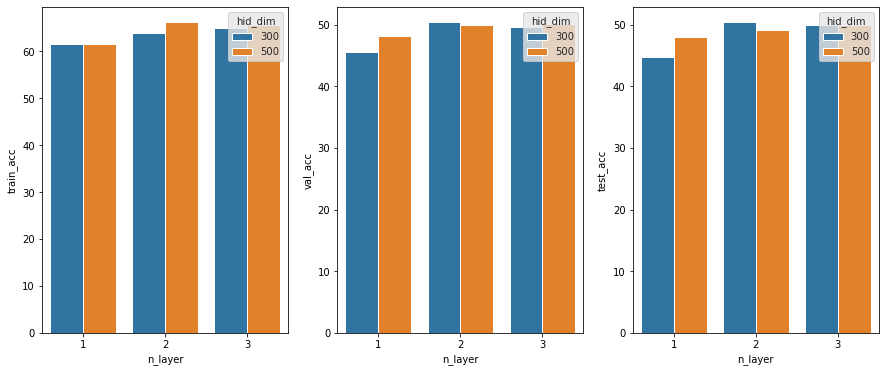

In [64]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

In [69]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

[1 2 3] [300 500]
1 300                                         train_losses  \
0  [2.1944318584575773, 1.538207830137508, 1.4708...   

                                          val_losses  \
0  [2.076296639442444, 1.8273275375366211, 1.6437...   

                                          train_accs  \
0  [38.555, 46.4875, 49.235, 51.5025, 53.47, 55.6...   

                                            val_accs  train_acc  val_acc  \
0  [36.19, 39.83, 44.51, 45.96, 47.96, 43.28, 42....    61.4925    45.58   

   test_acc              exp_name  in_dim  out_dim  hid_dim   act  dropout  \
0     44.73  exp1_n_layer_hid_dim    3072       10      300  relu      0.2   

   use_bn       l2  use_xavier    optim      lr  train_batch_size  n_layer  
0    True  0.00001        True  RMSprop  0.0015               256        1  
2 300                                         train_losses  \
1  [1.7606302833860847, 1.5190594462072773, 1.409...   

                                          val_losses  

KeyError: 'type'

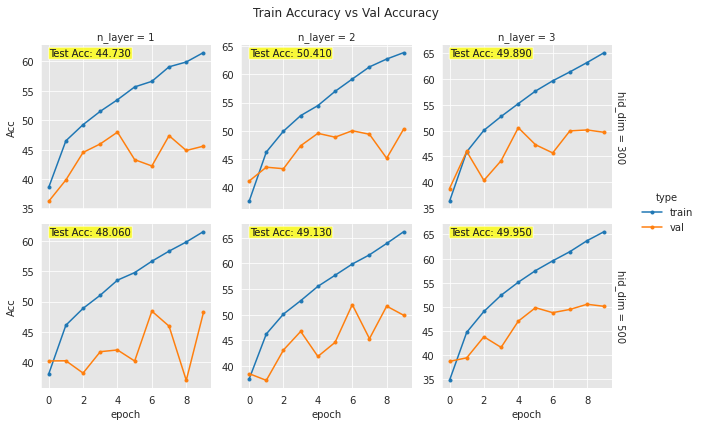

In [66]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

## 모델을 선정 후, 다른 hyperpatameter를 바꿔보자

In [70]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 300
args.act = 'relu'
args.n_layer=3

# ====== Regularization ======= #
#args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
#args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.0001, 0.0005, 0.001, 0.005, 0.01]
list_var2 = [0,0.1,0.2,0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) ## args.name_var1 = var1 과 같은 말
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=0.0001, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 41.41/43.72, Loss(train/val) 1.67/1.58. Took 3.35 sec
Epoch 1, Acc(train/val): 49.76/48.21, Loss(train/val) 1.44/1.48. Took 3.34 sec
Epoch 2, Acc(train/val): 53.83/48.85, Loss(train/val) 1.33/1.45. Took 3.37 sec
Epoch 3, Acc(train/val): 57.06/49.44, Loss(train/val) 1.24/1.43. Took 3.34 sec
Epoch 4, Acc(train/val): 59.87/49.69, Loss(train/val) 1.16/1.43. Took 3.36 sec
Epoch 5, Acc(train/val): 62.40/49.13, Loss(train/val) 1.09/1.45. Took 3.41 sec
Epoch 6, Acc(train/val): 65.10/49.09, Loss(train/val) 1.02/1.45. Took 3.40 sec
Epoch 7, Acc(train/val): 67.51/50.59, Loss(train/val) 0.96/1.43. Took 3.36 sec
Epoch 8, Acc(train/val): 69.73/47.86, Loss(train/val) 0.90/1.55. Took 3.38 sec
Epoch 9, Acc(train/val): 71.43/47.88, Loss(train/val) 0.8

<AxesSubplot:xlabel='lr', ylabel='test_acc'>

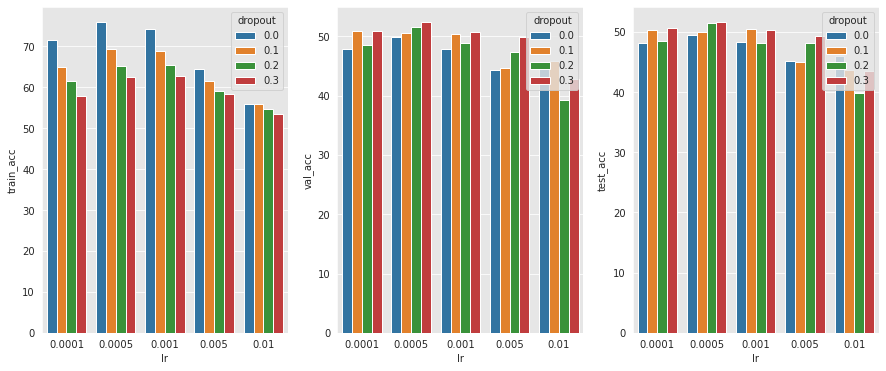

In [71]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp2')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='lr', y='train_acc', hue='dropout', data=df, ax=ax[0])
sns.barplot(x='lr', y='val_acc', hue='dropout', data=df, ax=ax[1])
sns.barplot(x='lr', y='test_acc', hue='dropout', data=df, ax=ax[2])

[0.001  0.0001 0.0005 0.01   0.005 ] [0.2 0.3 0.1 0. ]


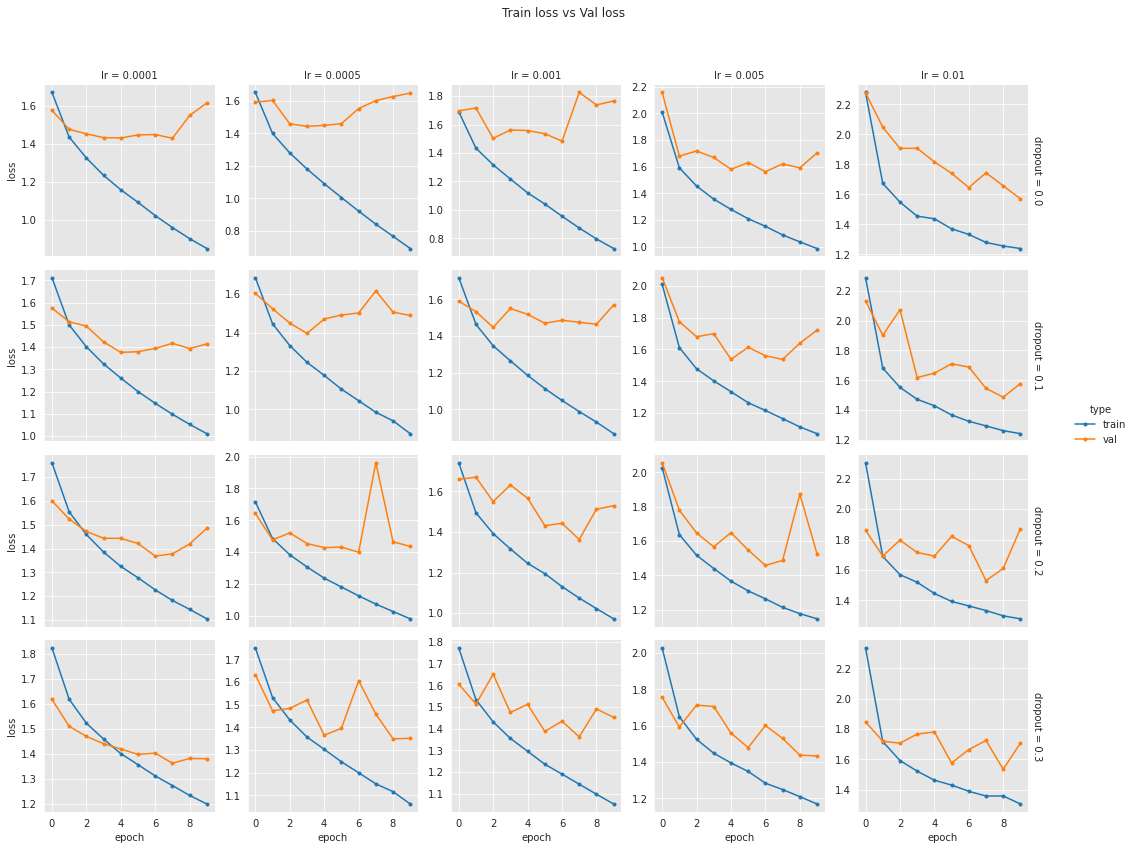

In [73]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
print(list_v1, list_v2)
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

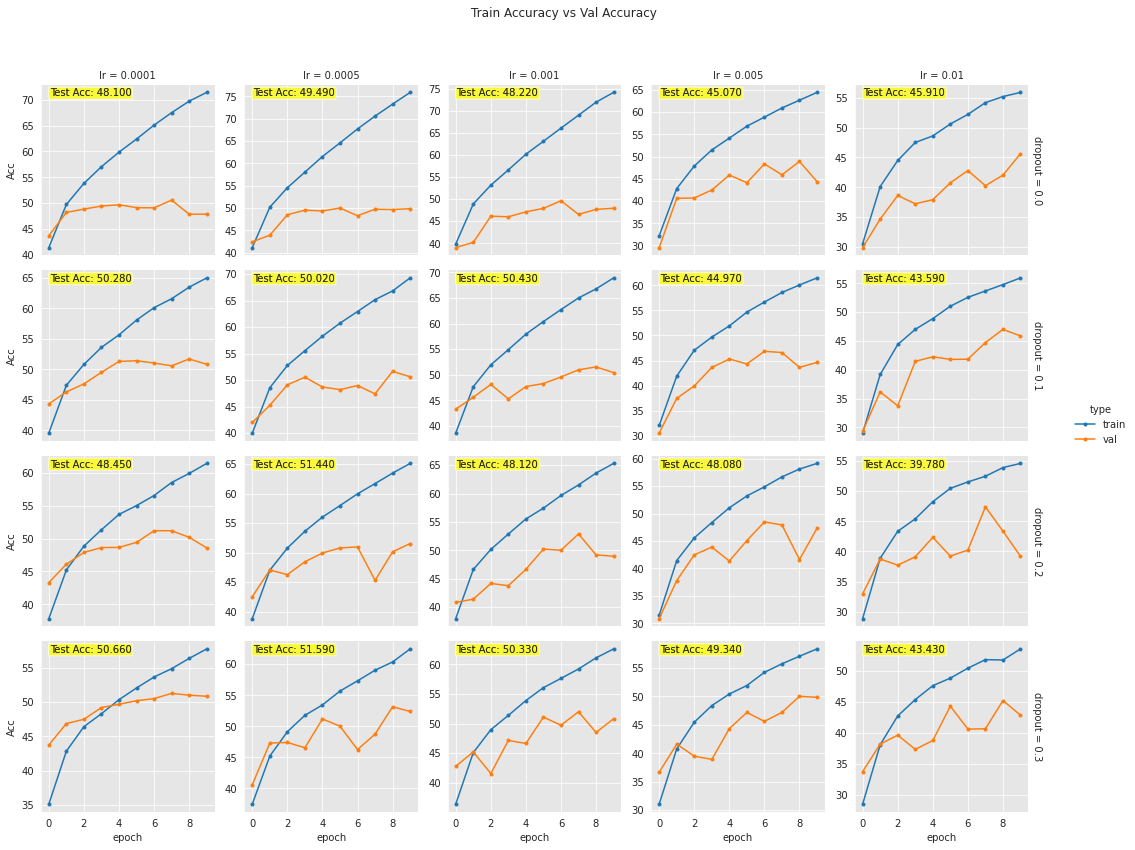

In [74]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)